In [3]:
# Importáljuk a szükséges modulokat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector as mysql
from matplotlib import style
%matplotlib inline

In [5]:
# Csatlakozzunk az adtbázishoz:
db = mysql.connect(
        host = 'localhost',
        user = 'ax07998',
        password = 'Abcd1234.',
        database = 'hu_monitor'
        )
print(db)

In [6]:
# Lássuk a queryt:
qry ="""SELECT UPPER(kezdAx)AS 'usr',kicsAllapot,kicsomKezdDat,kicsomVegDat,
time_to_sec(idotartam)/60 AS 'ido_perc',SOROK,totveight,totvol/1000 As 'vol',totDara
 FROM hu_monitor.kicsomdata
WHERE kezdAx = vegezAX AND idotartam > 0 AND idotartam < '05:00' AND kicsAllapot LIKE 'KICSOM V%';"""
# Olvassuk ki az adataokat egy dataframe-be
df = pd.read_sql(qry,db)

In [7]:
# Az első ellenőrzéshez elég a shape tuple-t használni.
# Ez memutatja, hogy hány sorunk, és oszlopunk van.
df.shape

(8290, 9)

In [8]:
# Nézzünk bele a dataframbe:
df.head()

,usr,kicsAllapot,kicsomKezdDat,kicsomVegDat,ido_perc,SOROK,totveight,vol,totDara
0,A141001,KICSOM VÉGE KISANY URGENT,2020-04-24 12:27:16,2020-04-24 12:11:34,15.7000,31,82.007,1656.262672,70
1,A141001,KICSOM VÉGE KISANY URGENT,2020-04-24 12:57:49,2020-04-24 12:28:30,29.3167,51,57.239,222.246145,146
2,A141001,KICSOM VÉGE KISANY URGENT,2020-04-24 13:13:24,2020-04-24 13:00:52,12.5333,16,42.188,234.003520,28
3,A141001,KICSOM VÉGE KISANY URGENT,2020-04-24 13:25:35,2020-04-24 13:13:31,12.0667,14,53.676,297.670664,18
4,A141001,KICSOM VÉGE KISANY URGENT,2020-04-24 14:00:13,2020-04-24 13:27:37,32.6000,72,28.120,96.131079,264


In [9]:
# Úgy tűnik minden OK:
# Nézzük meg az adattípusokat:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8290 entries, 0 to 8289
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   usr            8290 non-null   object        
 1   kicsAllapot    8290 non-null   object        
 2   kicsomKezdDat  8290 non-null   datetime64[ns]
 3   kicsomVegDat   8290 non-null   datetime64[ns]
 4   ido_perc       8290 non-null   float64       
 5   SOROK          8290 non-null   int64         
 6   totveight      8290 non-null   float64       
 7   vol            8290 non-null   float64       
 8   totDara        8290 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(2)
memory usage: 583.0+ KB


In [15]:
# Az adattípusok nagyjából rendben vannak, mert csak az első 2 object, ezekről tudjuk, h valóban szövegek.
# Lássuk a numerikus addatokra vonatkozó alapstatisztikát:
df.describe()

,ido_perc,SOROK,totveight,vol,totDara
count,8295.000000,8295.000000,8295.000000,8295.000000,8295.000000
mean,9.411488,14.026040,59.003363,576.839521,108.882218
std,13.717524,21.250122,108.965967,796.647440,334.593918
min,0.016700,1.000000,0.000000,0.000000,1.000000
25%,0.616700,2.000000,7.758000,62.240256,5.000000
50%,4.716700,7.000000,26.420000,228.690000,24.000000
75%,12.516700,17.000000,71.830000,841.424816,80.000000
max,266.616700,509.000000,4738.921000,9296.235000,9443.000000


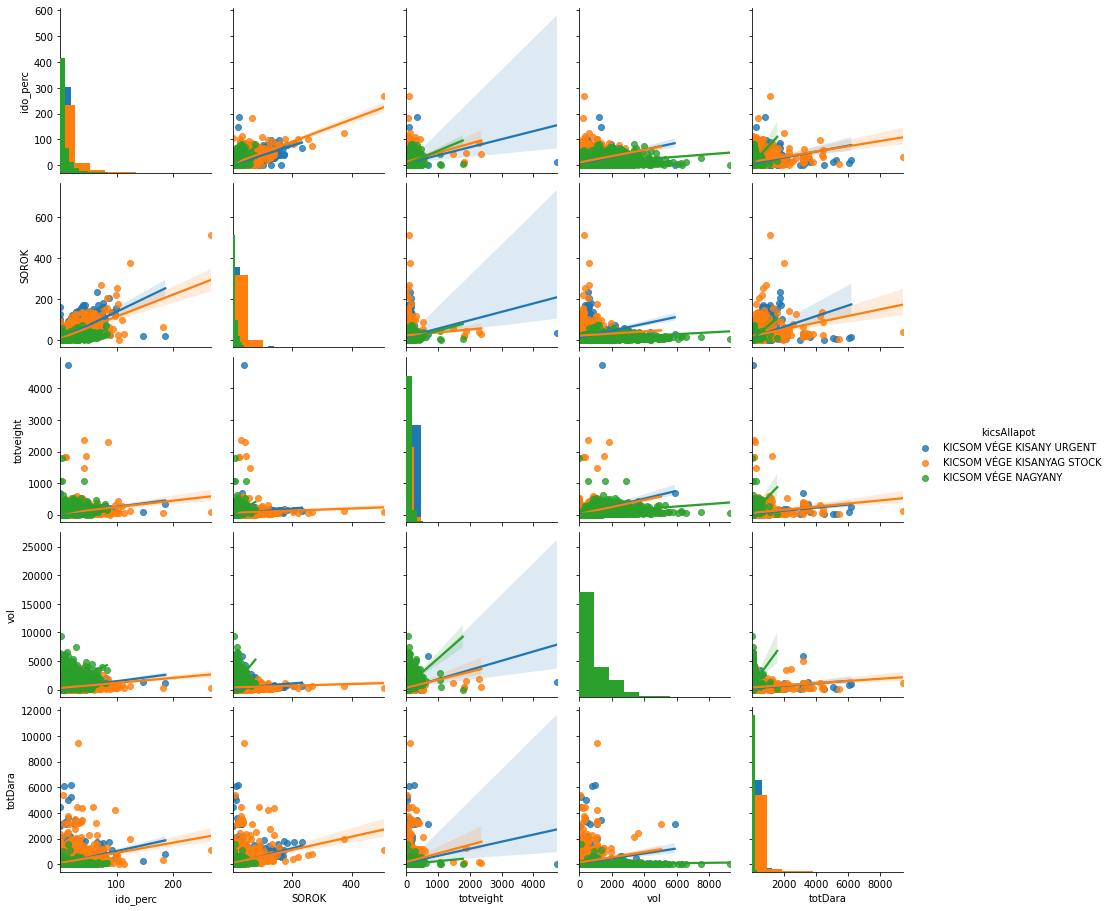

In [10]:
# Miután a fentiekből elég jól látszik, hogy igencsak szétszórt adataink vannak, lássunk egy kicsit vizuálisabb
# megközelítést:
sns.pairplot(data=df,hue='kicsAllapot',kind='reg',diag_kind='hist')

In [41]:
# Hogy lássuk ténleg milyen kusza, nézzük meg a kovaianciát, és a korrelációt:
print(df.cov())
print("==================================")
print(df.corr())

              ido_perc        SOROK     totveight            vol  \
ido_perc    188.250243   197.816047    477.347933    3175.028918   
SOROK       197.816047   451.729904    372.269034    1500.027719   
totveight   477.347933   372.269034  11879.228334   31367.005301   
vol        3175.028918  1500.027719  31367.005301  634874.287635   
totDara    1461.829487  2783.035192   5956.551732    8597.772592   

                 totDara  
ido_perc     1461.829487  
SOROK        2783.035192  
totveight    5956.551732  
vol          8597.772592  
totDara    112017.016272  
           ido_perc     SOROK  totveight       vol   totDara
ido_perc   1.000000  0.678351   0.319208  0.290426  0.318337
SOROK      0.678351  1.000000   0.160703  0.088576  0.391235
totveight  0.319208  0.160703   1.000000  0.361189  0.163290
vol        0.290426  0.088576   0.361189  1.000000  0.032240
totDara    0.318337  0.391235   0.163290  0.032240  1.000000


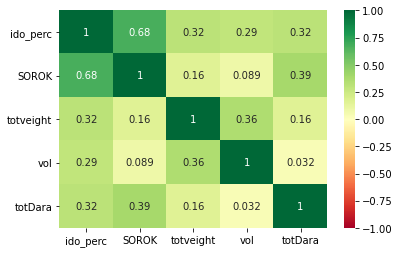

In [11]:
# Hát talán itt is többet segít egy kis vizualitás
sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap='RdYlGn',annot=True)

In [33]:
# Ez is elég kusza, szedjük szét kategóriákra!
df_ks = df.loc[df['kicsAllapot'] == 'KICSOM VÉGE KISANYAG STOCK']
print('SHAPE:',df_ks.shape)
print('=============================================')
df_ks.head()

SHAPE: (1979, 9)


,usr,kicsAllapot,kicsomKezdDat,kicsomVegDat,ido_perc,SOROK,totveight,vol,totDara
5,A141001,KICSOM VÉGE KISANYAG STOCK,2020-07-07 16:42:02,2020-07-07 14:59:36,102.4333,176,160.463,1097.812992,262
6,A630083,KICSOM VÉGE KISANYAG STOCK,2020-06-04 14:50:12,2020-06-04 14:14:56,35.2667,10,42.240,401.376000,120
63,AX03751,KICSOM VÉGE KISANYAG STOCK,2020-06-05 13:16:30,2020-06-05 12:51:39,24.8500,41,68.973,605.469910,102
64,AX03751,KICSOM VÉGE KISANYAG STOCK,2020-06-05 13:41:21,2020-06-05 13:23:08,18.2167,22,21.940,297.199013,54
65,AX03751,KICSOM VÉGE KISANYAG STOCK,2020-06-24 16:28:09,2020-06-24 16:27:30,0.6500,1,1.155,3.230760,10


In [37]:
df['kicsAllapot'].unique()
# Úgy tűnik, OK, lássuk a másik két kategóriát is:
# A biztonság kedvéért kérjük le az egyedi értékeket a 'kicsAllapot' oszlopra
df['kicsAllapot'].unique()
df_ku = df.loc[df['kicsAllapot'] == 'KICSOM VÉGE KISANY URGENT']
df_na = df.loc[df['kicsAllapot'] == 'KICSOM VÉGE NAGYANY']